# Sistemas Operacionais

## Laboratório 02 - Threads e comunicação entre processos

* Aluno: Arthur Emanuel Souza Cassiano da Costa
* Turma: T03
* Exercícios realizados: 1, 2, 4, 5

**Exercício 1**

Modifique o código acima para fazer com que dois processos filhos alterem uma memória compartilhada contendo um inteiro. Faça o processo pai esperar por seus dois filhos para depois imprimir o valor da variável na tela. Dica: olhe o código do exercício 3 do Laboratório 1.

In [1]:
%%writefile exercicio01.c
#include <stdio.h>
#include <stdlib.h>
#include <sys/types.h>
#include <sys/wait.h>
#include <unistd.h>
#include <sys/shm.h>
#include <sys/stat.h>

int main() {
    // Criando o segmento de memoria compartilhada com o tamanho de 1 int
    int segment_id = shmget(IPC_PRIVATE, sizeof(int), S_IRUSR | S_IWUSR);

    // Criando o ponteiro que vai apontar para o endereço de memória compartilhada
    int *shared_memory;

    // Anexando o segmento de memoria compartilhada ao processo pai
    shared_memory = (int *) shmat(segment_id, NULL, 0);

    // Gravando valor na memória compartilhada via processo pai
    *shared_memory = 1;

    printf("Valor inicial: %d\n", *shared_memory);

    // Desanexando a memória compartilhada
    shmdt(shared_memory);

    // Processo filho
    pid_t pid_filho = fork();

    if (pid_filho < 0) {
        printf("Sou o processo %d e não consegui criar o processo filho. T_T\n", getpid());
        return 1;
    } else if (pid_filho == 0) {
        // Anexando o segmento de memoria compartilhada
        shared_memory = (int *) shmat(segment_id, NULL, 0);

        // Escrevendo na memória compartilhada via processo
        *shared_memory += 1;

        // Desanexando a memória compartilhada
        shmdt(shared_memory);

        // Processo neto
        pid_t pid_neto = fork();

        if (pid_neto < 0) {
            printf("Sou o processo %d e não consegui criar o processo neto. T_T\n", getpid());
            return 1;
        } else if (pid_neto == 0) {
            // Anexando o segmento de memoria compartilhada
            shared_memory = (int *) shmat(segment_id, NULL, 0);

            // Escrevendo na memória compartilhada
            *shared_memory += 1;

            // Desanexando a memória compartilhada
            shmdt(shared_memory);

            printf("Processo neto escreveu na memória compartilhada.\n");

            // Encerrando o processo neto
            exit(0);
        } else {
            printf("Processo filho escreveu na memória compartilhada.\n");

            // Fazendo o processo filho esperar que o processo neto termine de escrever
            wait(NULL);
        }

        // Encerrando o processo filho
        exit(0);
    } else {
        printf("Processo pai escreveu na memória compartilhada.\n");

        // Fazendo o processo pai esperar que o processo filho termine de escrever
        wait(NULL);

        // Salvando o ponteiro que aponta para a memória compartilhada
        shared_memory = (int *) shmat(segment_id, NULL, 0);

        // Imprimindo o valor da área de memória compartilhada após
        // escritas feitas pelo processo filho e neto
        printf("Valor final: %d\n", *shared_memory);

        // Removendo o segmento de memória compartilhada
        shmctl(segment_id, IPC_RMID, NULL);
    }

    return 0;
}

Writing exercicio01.c


In [2]:
!gcc ./exercicio01.c -o exercicio01
!./exercicio01

Valor inicial: 1
Processo pai escreveu na memória compartilhada.
Processo filho escreveu na memória compartilhada.
Processo neto escreveu na memória compartilhada.
Valor final: 3


Nesse exercício, a variável teve inicialmente seu valor definido pelo processo pai para ser igual a `1`. Depois tanto o processo filho, quanto o processo neto incrementaram seu valor em uma unidade, portanto ao final da execução dos processos o valor da variável é `3`.

---

**Exercício 2**

Utilizando comunicação entre processos, crie um código que escreva a Sequência de Fibonacci, com o parâmetro `n` sendo uma variável global. Tal sequência deve ser gerada por um processo filho, mas deve ser impressa na tela pelo processo pai. Dica: olhe o código do desafio do Laboratório 1.

In [11]:
%%writefile exercicio02.c
#include <stdio.h>
#include <stdlib.h>
#include <sys/types.h>
#include <sys/wait.h>
#include <unistd.h>
#include <sys/shm.h>
#include <sys/stat.h>

int n = 20;

int main() {
    printf("Gerando os %d primeiros elementos da sequência de Fibonacci\n", n);
    printf("utilizando processos e área de memória compartilhada.\n\n");

    /* O processo filho fica responsável por gravar a sequência de Fibonacci
    na área de memória compartilhada. Enquanto que o processo pai faz a leitura
    da área de memória compartilhada e a imprime na tela.
    */

    // Criando o segmento de memoria compartilhada com o tamanho de n ints
    // para armazenar a sequencia de Fibonacci
    int segment_id = shmget(IPC_PRIVATE, n * sizeof(char), S_IRUSR | S_IWUSR);

    // Criando o ponteiro que vai apontar para o endereço de memória compartilhada
    int *shared_memory;

    pid_t pid = fork();

    if (pid < 0) {
        printf("Sou o processo %d e não consegui criar um novo processo.\n", getpid());
        return 1;
    } else if (pid == 0) {
        // Anexando o segmento de memoria compartilhada
        shared_memory = (int *) shmat(segment_id, NULL, 0);

        if (n == 1) {
            shared_memory[0] = 1;
        } else if (n == 2) {
            shared_memory[0] = 1;
            shared_memory[1] = 1;
        } else {
            shared_memory[0] = 1;
            shared_memory[1] = 1;
            for (int i = 2; i < n; i++) {
                shared_memory[i] = shared_memory[i - 1] + shared_memory[i - 2];
            }
        }

        // Desanexando a memória compartilhada
        shmdt(shared_memory);

        // Encerrando o processo filho
        exit(0);
    } else {
        // Fazendo o pai esperar que o filho termine de escrever os valores
        // na área de memória compartilhada
        wait(NULL);

        // Salvando o ponteiro que aponta para a memória compartilhada
        shared_memory = (int *) shmat(segment_id, NULL, 0);

        // Imprimindo conteúdo deixado pelo processo filho
        // na área de memória compartilhada
        for (int i = 0; i < n; i++) {
            printf("%d ", shared_memory[i]);
        }
        printf("\n");

        // Removendo o segmento de memória compartilhada
        shmctl(segment_id, IPC_RMID, NULL);
    }

    return 0;
}

Overwriting exercicio02.c


In [12]:
!gcc ./exercicio02.c -o exercicio02
!./exercicio02

Gerando os 20 primeiros elementos da sequência de Fibonacci
utilizando processos e área de memória compartilhada.

1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 


**Exercício 4**

Comente a linha `pthread_join(threads[i],NULL)` no código acima e veja o que acontece. Qual o motivo da mudança no output? Faça modificações no código para obter novamente a saída original sem necessitar usar um `threads_join`. Dica: threads também podem dormir.

**Primeira parte**: executando o código sem o trecho `pthread_join(threads[i], NULL)`.

In [18]:
%%writefile exercicio04-parte01.c
#include <pthread.h>
#include <stdio.h>
#include <stdlib.h>
#include <sys/types.h>
#include <sys/wait.h>
#include <sys/shm.h>
#include <sys/stat.h>
#include <unistd.h>

int number_of_threads = 5;

// Função usada pelas threads para dizer 'Olá!'
void *print_hello(void *tid) {
    printf("Olá, eu sou a thread %d.\n", (int)(size_t) tid);
    pthread_exit(NULL);
}

int main() {
    pthread_t threads[number_of_threads];

    for (int i = 0; i < number_of_threads; i++) {
        // Criando uma thread e passando para ela a função print_hello
        int status = pthread_create(&threads[i], NULL, print_hello, (void *)(size_t) i);

        if (status != 0) {
            printf("Erro na criação da thread %d. Código de erro: %d\n", i, status);
            return 1;
        }

        // Faz a thread principal esperar pela thread filha. Similar a funcao wait.
        // pthread_join(threads[i], NULL);
    }

    return 0;
}

Overwriting exercicio04-parte01.c


In [20]:
!gcc exercicio04-parte01.c -o exercicio04-parte01
!./exercicio04

Olá, eu sou a thread 0.
Olá, eu sou a thread 1.
Olá, eu sou a thread 2.
Olá, eu sou a thread 3.
Olá, eu sou a thread 4.


Ao executar o código com o trecho `pthread_join(threads[i], NULL)` comentado no Google Colab aconteceu algo bastante interessante. A execução das threads ocorreu de forma sequencial e todas as threads foram executadas e tiveram sua mensagem exibida. Entretanto, ao executar o código em minha máquina percebi que a ordem de execução das threads mudavam, não era necessariamente do 0 ao 4, e nem todas as 5 threads eram executadas, conforme mostra as várias execuções na imagem abaixo:

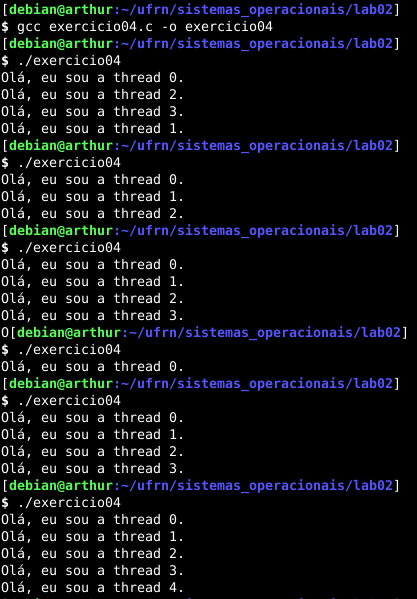

Isso provavelmente ocorreu porque as threads foram criadas dentro do `for` loop e não foram escalonadas de forma sequencial. E como o `pthread_join` foi removido do código, o programa não espera que as threads terminem a sua execução, então provavelmente as threads são criadas e a thread principal continua a execução da função `main` que deve chegar na última linha onde há o `return 0` que finaliza o programa e consequentemente todas as threads criadas.

O código asseguir mostra uma solução para esse problema usando a chamada de sistema `sleep`:

**Segunda parte**: executando o código com o `sleep`

In [21]:
%%writefile exercicio04-parte02.c
#include <pthread.h>
#include <stdio.h>
#include <stdlib.h>
#include <sys/types.h>
#include <sys/wait.h>
#include <sys/shm.h>
#include <sys/stat.h>
#include <unistd.h>

int number_of_threads = 5;

// Função usada pelas threads para dizer 'Olá!'
void *print_hello(void *tid) {
    printf("Olá, eu sou a thread %d.\n", (int)(size_t) tid);
    pthread_exit(NULL);
}

int main() {
    pthread_t threads[number_of_threads];

    for (int i = 0; i < number_of_threads; i++) {
        // Criando uma thread e passando para ela a função print_hello
        int status = pthread_create(&threads[i], NULL, print_hello, (void *)(size_t) i);

        if (status != 0) {
            printf("Erro na criação da thread %d. Código de erro: %d\n", i, status);
            return 1;
        }

        sleep(1);

        // Faz a thread principal esperar pela thread filha. Similar a funcao wait.
        // pthread_join(threads[i], NULL);
    }

    return 0;
}

Writing exercicio04-parte02.c


In [22]:
!gcc exercicio04-parte02.c -o exercicio04-parte02
!./exercicio04-parte02

Olá, eu sou a thread 0.
Olá, eu sou a thread 1.
Olá, eu sou a thread 2.
Olá, eu sou a thread 3.
Olá, eu sou a thread 4.


Agora todas as threads são executadas e a execução ocorre de forma sequencial com uma pausa de 1 segundo entre elas.

Obs.: esse resultado também foi obtido localmente.

**Exercício 5**

Refaça o exercício 2 usando threads.

In [25]:
%%writefile exercicio05.c
#include <pthread.h>
#include <stdio.h>
#include <stdlib.h>
#include <sys/types.h>
#include <sys/wait.h>
#include <sys/shm.h>
#include <sys/stat.h>
#include <unistd.h>

#define n 15

int number_of_threads = n;
int fib[n];

void *calcular_fibonacci(void *tid) {
    size_t i = (size_t) tid;

    if (i == 0) {
        fib[0] = 1;
    } else if (i == 1) {
        fib[1] = 1;
    } else {
        fib[i] = fib[i - 1] + fib[i - 2];
    }

    pthread_exit(NULL);
}

void *mostrar_valor(void *tid) {
    printf("%d ", fib[(size_t) tid]);
    pthread_exit(NULL);
}

int main() {
    printf("Primeiro %d termos da sequência de Fibonacci criados usando threads.\n\n", n);
    pthread_t threads[number_of_threads];

    // Criando threads para calcular a sequência de fibonacci
    for (int i = 0; i < number_of_threads; i++) {
        int status = pthread_create(&threads[i], NULL, calcular_fibonacci, (void *)(size_t) i);

        if (status != 0) {
            printf("Erro na criação da thread %d. Código de erro %d.", i, status);
            return 1;
        }

        pthread_join(threads[i], NULL);
    }

    // Criando threads para mostrar os elementos da sequência de fibonacci
    // que foram criados anteriormente
    for (int i = 0; i < number_of_threads; i++) {
        int status = pthread_create(&threads[i], NULL, mostrar_valor, (void *)(size_t) i);

        if (status != 0) {
            printf("Erro na criação da thread %d. Código de erro %d.", i, status);
            return 1;
        }

        pthread_join(threads[i], NULL);
    }

    printf("\n");

    return 0;
}

Overwriting exercicio05.c


In [26]:
!gcc exercicio05.c -o exercicio05
!./exercicio05

Primeiro 15 termos da sequência de Fibonacci criados usando threads.

1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 


Obs.: Foi utilizado a macro `#define n 15`, pois o compilador não permitiu criar uma variável global com `int n = 15` e usar essa variável como o tamanho do array em `int fib[n]`.